In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
#Clear any previous models
tf.keras.backend.clear_session()
#Create directories for saving images
os.makedirs('images', exist_ok=True)

In [ ]:
#Load and preprocess MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  #Normalize to [-1, 1]
X_train = X_train.reshape(60000, 784)  #Flatten to 784 pixels

#Set random dimension for noise input
randomDim = 100

In [ ]:
print("Building Generator...")
#Build Generator - takes random noise vector (100-dim) as input
#and outputs a flattened MNIST-like image (784-dim)
generator = Sequential([
    #First hidden layer: fully connected with 256 neurons
    Dense(256, input_shape=(randomDim,)),
    #LeakyReLU activation (slope=0.2 for negative values) for stability
    LeakyReLU(0.2),

    #Second hidden layer: 512 neurons
    Dense(512),
    LeakyReLU(0.2),

    #Third hidden layer: 1024 neurons
    Dense(1024),
    LeakyReLU(0.2),

    #Output layer: 784 neurons (28x28 pixels flattened),
    #using 'tanh' so outputs are scaled to [-1, 1],
    #which matches the normalized MNIST dataset
    Dense(784, activation='tanh')
], name='generator')


print("Building Discriminator...")
#Build Discriminator - takes an image vector (784-dim) as input
#and outputs a single probability (real vs fake)
discriminator = Sequential([
    #First hidden layer: 1024 neurons, expects input of size 784
    Dense(1024, input_shape=(784,)),
    LeakyReLU(0.2),
    #Dropout to reduce overfitting and stabilize GAN training
    Dropout(0.3),

    #Second hidden layer: 512 neurons
    Dense(512),
    LeakyReLU(0.2),
    Dropout(0.3),

    #Third hidden layer: 256 neurons
    Dense(256),
    LeakyReLU(0.2),
    Dropout(0.3),

    #Output layer: 1 neuron with sigmoid activation,
    #producing probability of input being "real"
    Dense(1, activation='sigmoid')
], name='discriminator')


print("Generator summary:")
#Prints architecture and parameter count for generator
generator.summary()

print("\nDiscriminator summary:")
#Prints architecture and parameter count for discriminator
discriminator.summary()

#Compile discriminator with binary crossentropy loss
#and Adam optimizer (lr=0.0002, beta1=0.5),
#which is a standard GAN setup
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Building Generator...
Building Discriminator...
Generator summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Building combined GAN...")
#To train the Generator, we build a combined model:
#  Noise (randomDim) → Generator → Discriminator → Probability
#The Discriminator is frozen (non-trainable) so only the Generator updates
discriminator.trainable = False

#Define GAN input: random noise vector
gan_input = Input(shape=(randomDim,))

#Pass noise through generator to produce a fake image
generated_image = generator(gan_input)

#Pass generated image through discriminator to get real/fake probability
gan_output = discriminator(generated_image)

#Define GAN model: input = noise, output = discriminator’s decision
gan = Model(inputs=gan_input, outputs=gan_output, name='gan')

#Compile with binary crossentropy loss + Adam optimizer
#This ensures that during training, the generator learns to "fool" the discriminator
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

print("GAN summary:")
#Prints the architecture: Noise → Generator → Discriminator
gan.summary()


#Lists to store loss history for plotting later
dLosses = []  #Discriminator losses
gLosses = []  #Generator losses

#Helper function: Save generated images during training
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    #Generate random noise
    noise = np.random.normal(0, 1, size=[examples, randomDim])

    #Use generator to create fake images
    generatedImages = generator.predict(noise)

    #Reshape to 28x28 for visualization
    generatedImages = generatedImages.reshape(examples, 28, 28)

    #Plot grid of generated images
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

    #Save to file (organized by epoch)
    plt.savefig(f'images/gan_generated_image_epoch_{epoch}.png')
    plt.show()

#Helper function: Plot training losses
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminator loss')
    plt.plot(gLosses, label='Generator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'images/gan_loss_epoch_{epoch}.png')
    plt.show()


#Training function
def train(epochs=1, batchSize=128):
    #Number of batches per epoch
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    #Loop through epochs
    for e in range(1, epochs + 1):
        print('-' * 15, f'Epoch {e}', '-' * 15)

        #Loop through all batches
        for batch_idx in range(batchCount):
            #Train Discriminator
            #Sample random noise and real images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            #Generate fake images from noise
            generatedImages = generator.predict(noise, verbose=0)

            #Combine real + fake images
            X = np.concatenate([imageBatch, generatedImages])

            #Labels: real = 0.9 (smoothed), fake = 0
            yDis = np.zeros(2 * batchSize)
            yDis[:batchSize] = 0.9  #one-sided label smoothing

            #Train discriminator on real+fake data
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            #Train Generator
            #New random noise
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])

            #Labels are "real" (1) because generator wants to fool discriminator
            yGen = np.ones(batchSize)

            #Freeze discriminator during generator training
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

            #Print batch progress every 100 batches
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{batchCount}: "
                      f"D loss: {dloss:.4f}, G loss: {gloss:.4f}")

        #End of epoch: store losses
        dLosses.append(dloss)
        gLosses.append(gloss)

        print(f"Epoch {e} completed: "
              f"Discriminator Loss: {dloss:.4f}, Generator Loss: {gloss:.4f}")

        #Save sample images every 20 epochs (and on epoch 1)
        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)

        #Plot loss curves every 50 epochs
        if e % 50 == 0:
            plotLoss(e)

Building combined GAN...
GAN summary:


Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 784)            │     1,486,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │     1,460,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,946,577 (11.24 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 1,460,225 (5.57 MB)


Testing model structure...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Test successful! Generated image shape: (1, 784), Discrimination output: [[0.5600888]]

Starting GAN training...
Epochs: 100
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
Batch 0/468: D loss: 0.6348, G loss: 0.6679
Batch 100/468: D loss: 0.6129, G loss: 0.9192
Batch 200/468: D loss: 0.5737, G loss: 1.0048
Batch 300/468: D loss: 0.5425, G loss: 1.1700
Batch 400/468: D loss: 0.5288, G loss: 1.3016
Epoch 1 completed: Discriminator Loss: 0.5221, Generator Loss: 1.3746
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


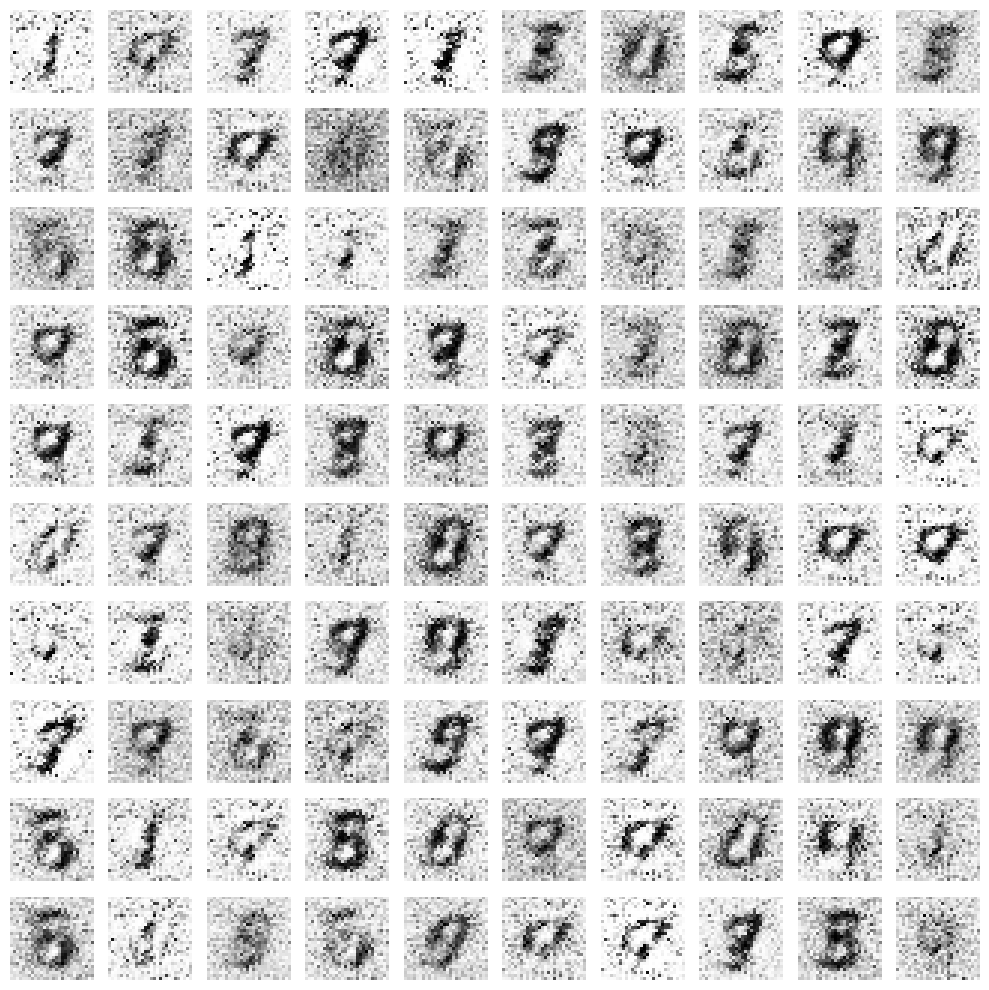

--------------- Epoch 2 ---------------
Batch 0/468: D loss: 0.5220, G loss: 1.3750
Batch 100/468: D loss: 0.5169, G loss: 1.4538
Batch 200/468: D loss: 0.5084, G loss: 1.5369
Batch 300/468: D loss: 0.5055, G loss: 1.5952
Batch 400/468: D loss: 0.5023, G loss: 1.6332
Epoch 2 completed: Discriminator Loss: 0.5007, Generator Loss: 1.6519
--------------- Epoch 3 ---------------
Batch 0/468: D loss: 0.5007, G loss: 1.6519
Batch 100/468: D loss: 0.4980, G loss: 1.6776
Batch 200/468: D loss: 0.4958, G loss: 1.7035
Batch 300/468: D loss: 0.4934, G loss: 1.7259
Batch 400/468: D loss: 0.4899, G loss: 1.7463
Epoch 3 completed: Discriminator Loss: 0.4890, Generator Loss: 1.7537
--------------- Epoch 4 ---------------
Batch 0/468: D loss: 0.4890, G loss: 1.7535
Batch 100/468: D loss: 0.4872, G loss: 1.7650
Batch 200/468: D loss: 0.4854, G loss: 1.7784
Batch 300/468: D loss: 0.4835, G loss: 1.7946
Batch 400/468: D loss: 0.4820, G loss: 1.8117
Epoch 4 completed: Discriminator Loss: 0.4817, Generator

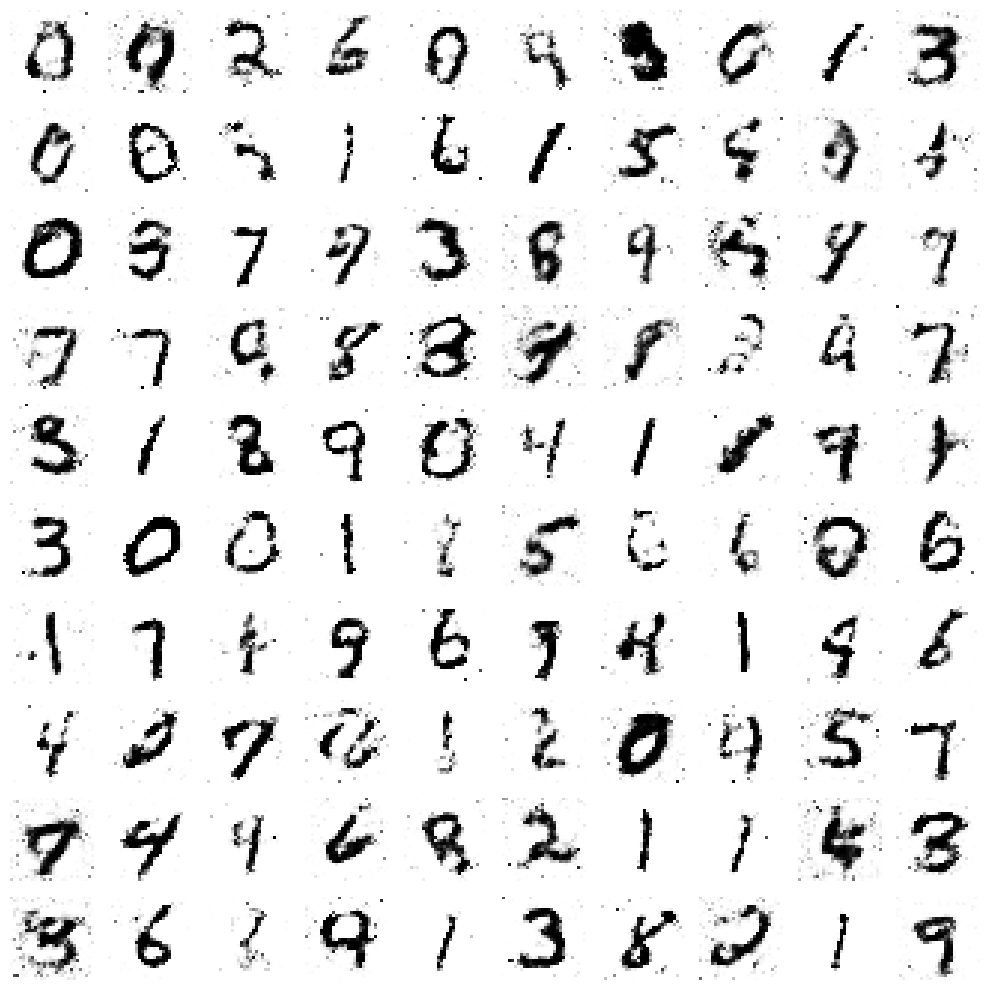

--------------- Epoch 21 ---------------
Batch 0/468: D loss: 0.5583, G loss: 1.4250
Batch 100/468: D loss: 0.5591, G loss: 1.4213
Batch 200/468: D loss: 0.5598, G loss: 1.4175
Batch 300/468: D loss: 0.5605, G loss: 1.4138
Batch 400/468: D loss: 0.5612, G loss: 1.4103
Epoch 21 completed: Discriminator Loss: 0.5617, Generator Loss: 1.4079
--------------- Epoch 22 ---------------
Batch 0/468: D loss: 0.5617, G loss: 1.4079
Batch 100/468: D loss: 0.5623, G loss: 1.4045
Batch 200/468: D loss: 0.5630, G loss: 1.4012
Batch 300/468: D loss: 0.5636, G loss: 1.3978
Batch 400/468: D loss: 0.5643, G loss: 1.3944
Epoch 22 completed: Discriminator Loss: 0.5647, Generator Loss: 1.3923
--------------- Epoch 23 ---------------
Batch 0/468: D loss: 0.5647, G loss: 1.3923
Batch 100/468: D loss: 0.5653, G loss: 1.3891
Batch 200/468: D loss: 0.5659, G loss: 1.3860
Batch 300/468: D loss: 0.5665, G loss: 1.3829
Batch 400/468: D loss: 0.5671, G loss: 1.3800
Epoch 23 completed: Discriminator Loss: 0.5675, Gen

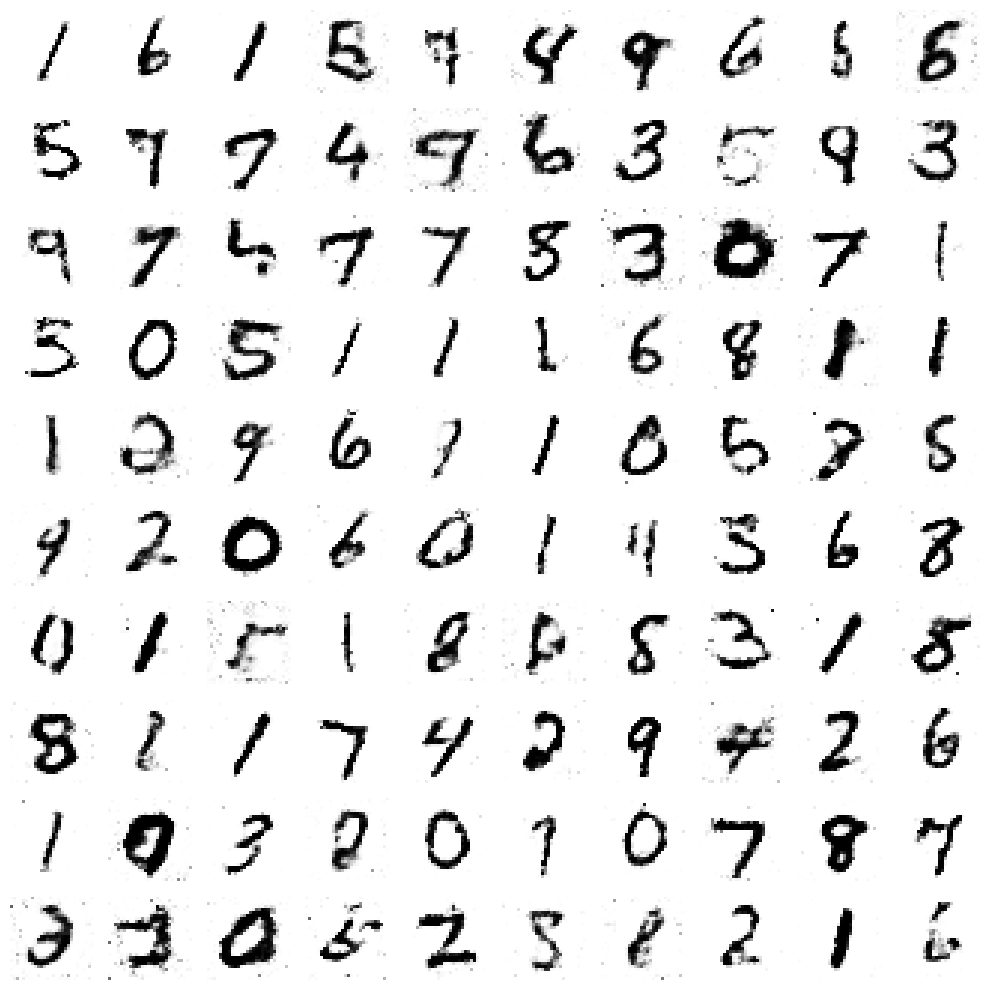

--------------- Epoch 41 ---------------
Batch 0/468: D loss: 0.5966, G loss: 1.2303
Batch 100/468: D loss: 0.5968, G loss: 1.2291
Batch 200/468: D loss: 0.5971, G loss: 1.2280
Batch 300/468: D loss: 0.5973, G loss: 1.2269
Batch 400/468: D loss: 0.5975, G loss: 1.2259
Epoch 41 completed: Discriminator Loss: 0.5976, Generator Loss: 1.2252
--------------- Epoch 42 ---------------
Batch 0/468: D loss: 0.5976, G loss: 1.2252
Batch 100/468: D loss: 0.5978, G loss: 1.2240
Batch 200/468: D loss: 0.5981, G loss: 1.2229
Batch 300/468: D loss: 0.5983, G loss: 1.2219
Batch 400/468: D loss: 0.5985, G loss: 1.2208
Epoch 42 completed: Discriminator Loss: 0.5986, Generator Loss: 1.2201
--------------- Epoch 43 ---------------
Batch 0/468: D loss: 0.5986, G loss: 1.2200
Batch 100/468: D loss: 0.5988, G loss: 1.2190
Batch 200/468: D loss: 0.5990, G loss: 1.2180
Batch 300/468: D loss: 0.5992, G loss: 1.2170
Batch 400/468: D loss: 0.5994, G loss: 1.2160
Epoch 43 completed: Discriminator Loss: 0.5996, Gen

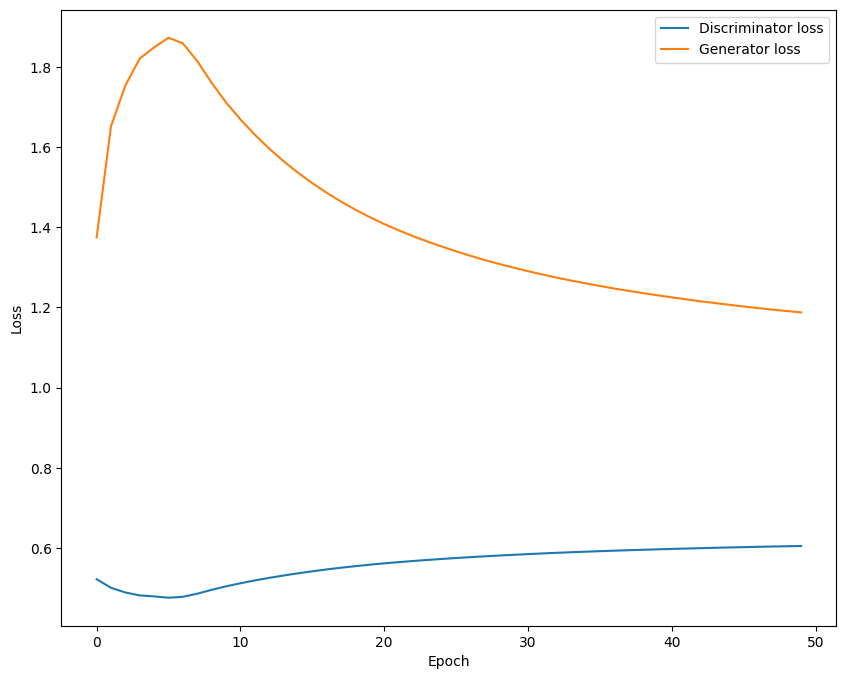

--------------- Epoch 51 ---------------
Batch 0/468: D loss: 0.6050, G loss: 1.1876
Batch 100/468: D loss: 0.6051, G loss: 1.1869
Batch 200/468: D loss: 0.6053, G loss: 1.1862
Batch 300/468: D loss: 0.6054, G loss: 1.1855
Batch 400/468: D loss: 0.6056, G loss: 1.1848
Epoch 51 completed: Discriminator Loss: 0.6056, Generator Loss: 1.1843
--------------- Epoch 52 ---------------
Batch 0/468: D loss: 0.6056, G loss: 1.1843
Batch 100/468: D loss: 0.6058, G loss: 1.1836
Batch 200/468: D loss: 0.6059, G loss: 1.1829
Batch 300/468: D loss: 0.6061, G loss: 1.1823
Batch 400/468: D loss: 0.6062, G loss: 1.1815
Epoch 52 completed: Discriminator Loss: 0.6063, Generator Loss: 1.1811
--------------- Epoch 53 ---------------
Batch 0/468: D loss: 0.6063, G loss: 1.1811
Batch 100/468: D loss: 0.6064, G loss: 1.1804
Batch 200/468: D loss: 0.6065, G loss: 1.1797
Batch 300/468: D loss: 0.6067, G loss: 1.1790
Batch 400/468: D loss: 0.6068, G loss: 1.1783
Epoch 53 completed: Discriminator Loss: 0.6069, Gen

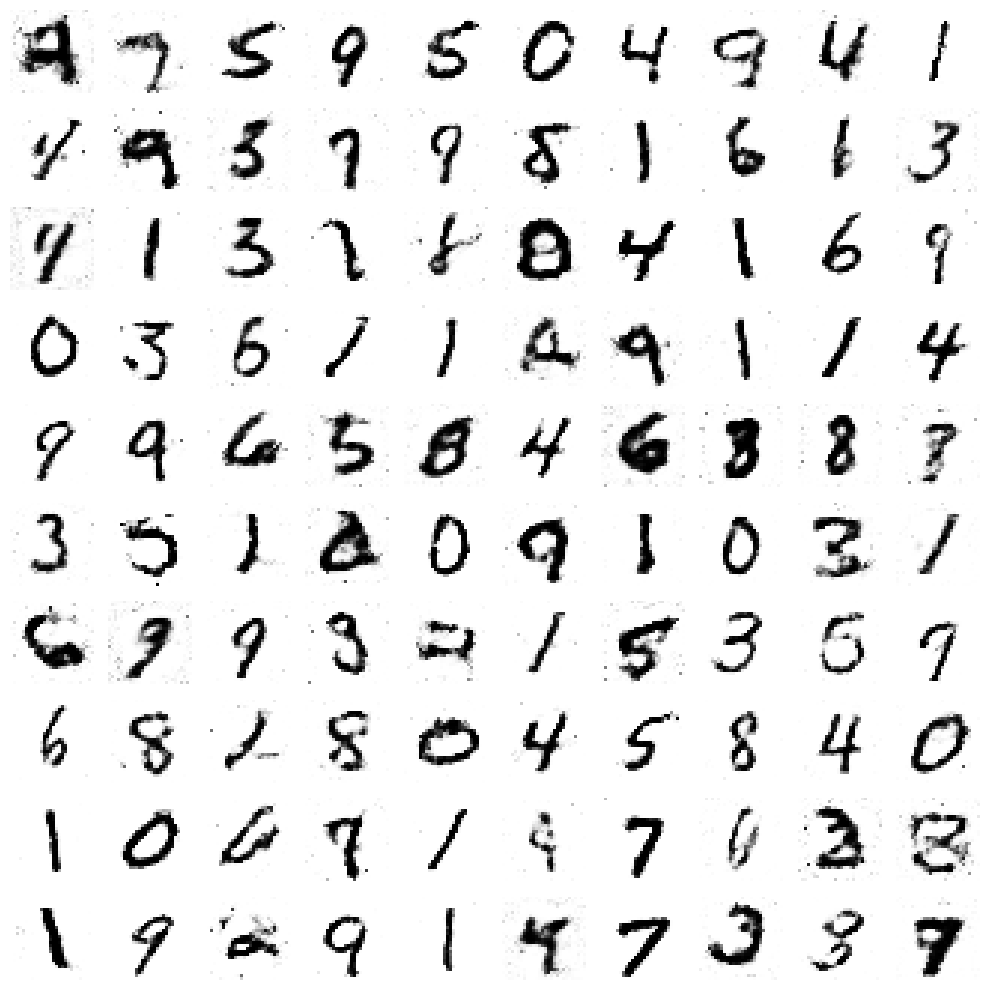

--------------- Epoch 61 ---------------
Batch 0/468: D loss: 0.6105, G loss: 1.1590
Batch 100/468: D loss: 0.6106, G loss: 1.1585
Batch 200/468: D loss: 0.6107, G loss: 1.1579
Batch 300/468: D loss: 0.6108, G loss: 1.1575
Batch 400/468: D loss: 0.6109, G loss: 1.1569
Epoch 61 completed: Discriminator Loss: 0.6110, Generator Loss: 1.1566
--------------- Epoch 62 ---------------
Batch 0/468: D loss: 0.6110, G loss: 1.1566
Batch 100/468: D loss: 0.6111, G loss: 1.1561
Batch 200/468: D loss: 0.6112, G loss: 1.1556
Batch 300/468: D loss: 0.6113, G loss: 1.1551
Batch 400/468: D loss: 0.6114, G loss: 1.1546
Epoch 62 completed: Discriminator Loss: 0.6115, Generator Loss: 1.1543
--------------- Epoch 63 ---------------
Batch 0/468: D loss: 0.6115, G loss: 1.1543
Batch 100/468: D loss: 0.6115, G loss: 1.1538
Batch 200/468: D loss: 0.6116, G loss: 1.1533
Batch 300/468: D loss: 0.6117, G loss: 1.1528
Batch 400/468: D loss: 0.6118, G loss: 1.1523
Epoch 63 completed: Discriminator Loss: 0.6119, Gen

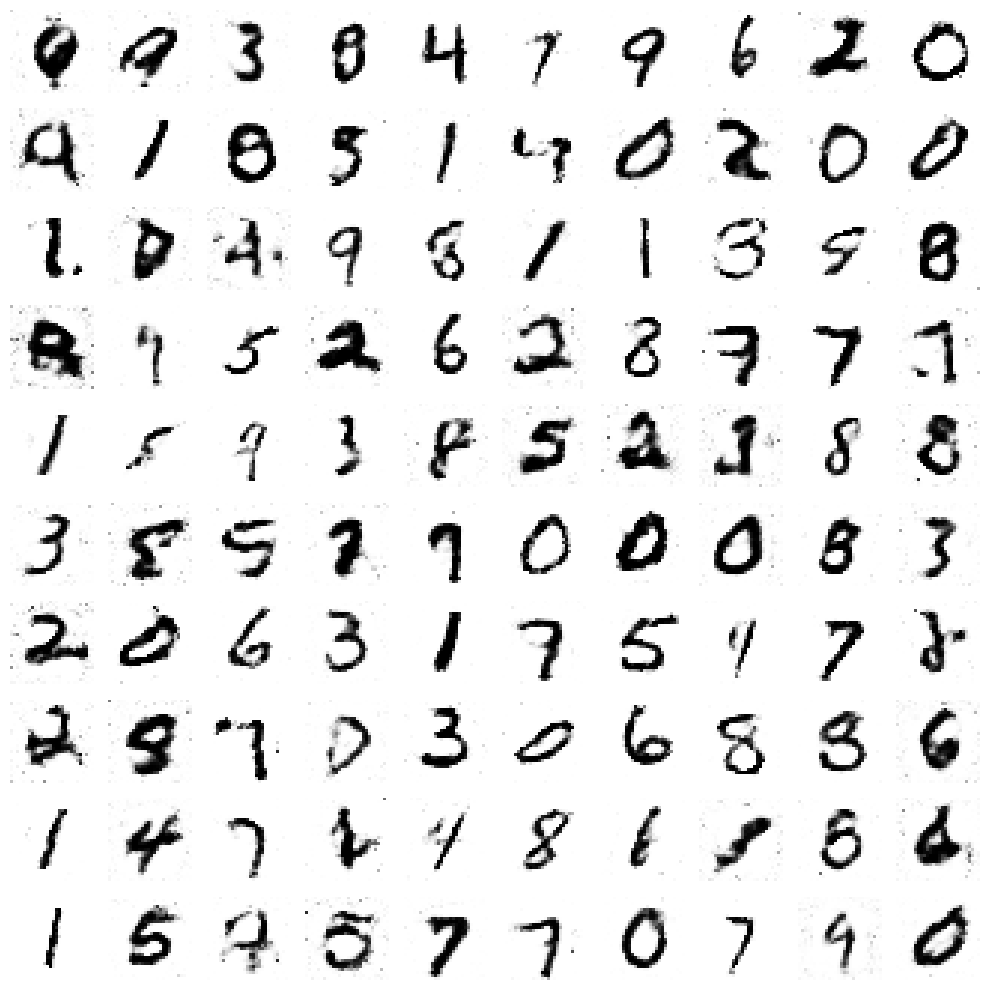

--------------- Epoch 81 ---------------
Batch 0/468: D loss: 0.6173, G loss: 1.1230
Batch 100/468: D loss: 0.6173, G loss: 1.1228
Batch 200/468: D loss: 0.6174, G loss: 1.1225
Batch 300/468: D loss: 0.6174, G loss: 1.1222
Batch 400/468: D loss: 0.6175, G loss: 1.1219
Epoch 81 completed: Discriminator Loss: 0.6175, Generator Loss: 1.1217
--------------- Epoch 82 ---------------
Batch 0/468: D loss: 0.6175, G loss: 1.1217
Batch 100/468: D loss: 0.6176, G loss: 1.1214
Batch 200/468: D loss: 0.6176, G loss: 1.1212
Batch 300/468: D loss: 0.6177, G loss: 1.1209
Batch 400/468: D loss: 0.6177, G loss: 1.1206
Epoch 82 completed: Discriminator Loss: 0.6178, Generator Loss: 1.1204
--------------- Epoch 83 ---------------
Batch 0/468: D loss: 0.6178, G loss: 1.1204
Batch 100/468: D loss: 0.6178, G loss: 1.1202
Batch 200/468: D loss: 0.6179, G loss: 1.1199
Batch 300/468: D loss: 0.6179, G loss: 1.1197
Batch 400/468: D loss: 0.6180, G loss: 1.1194
Epoch 83 completed: Discriminator Loss: 0.6180, Gen

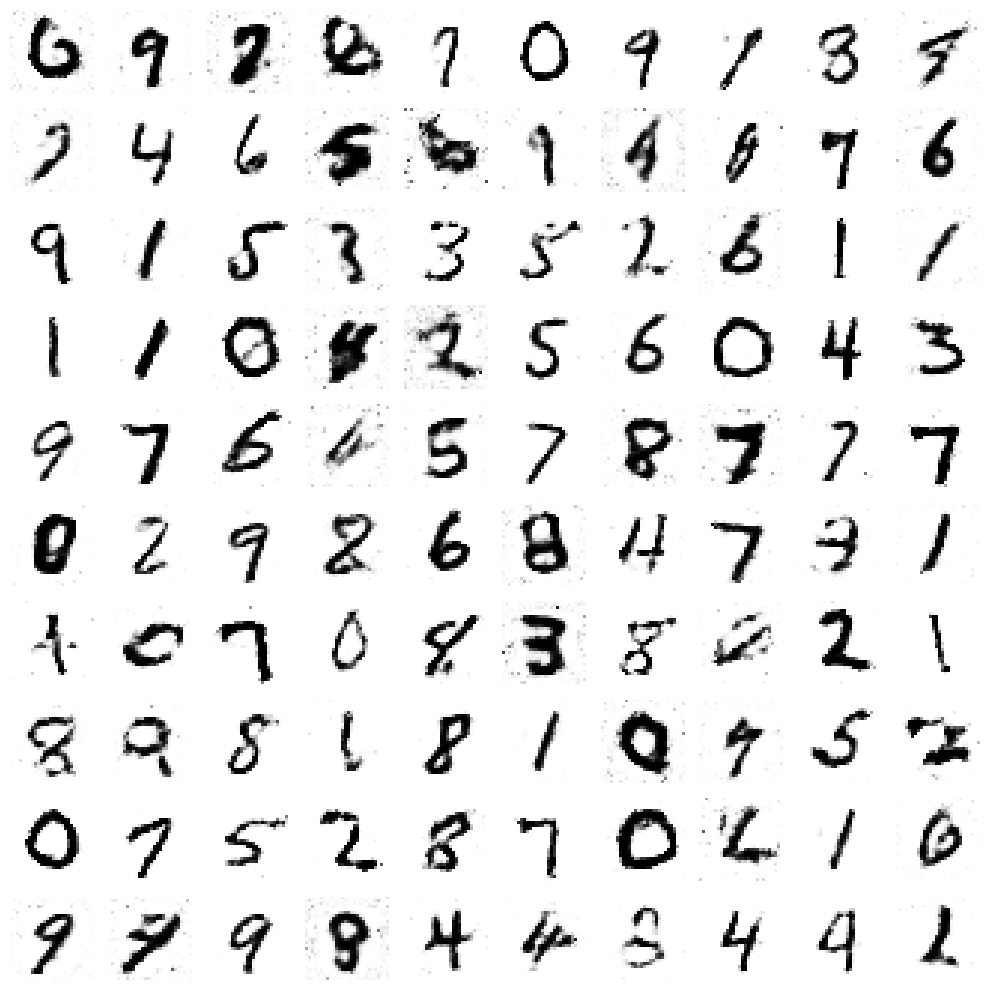

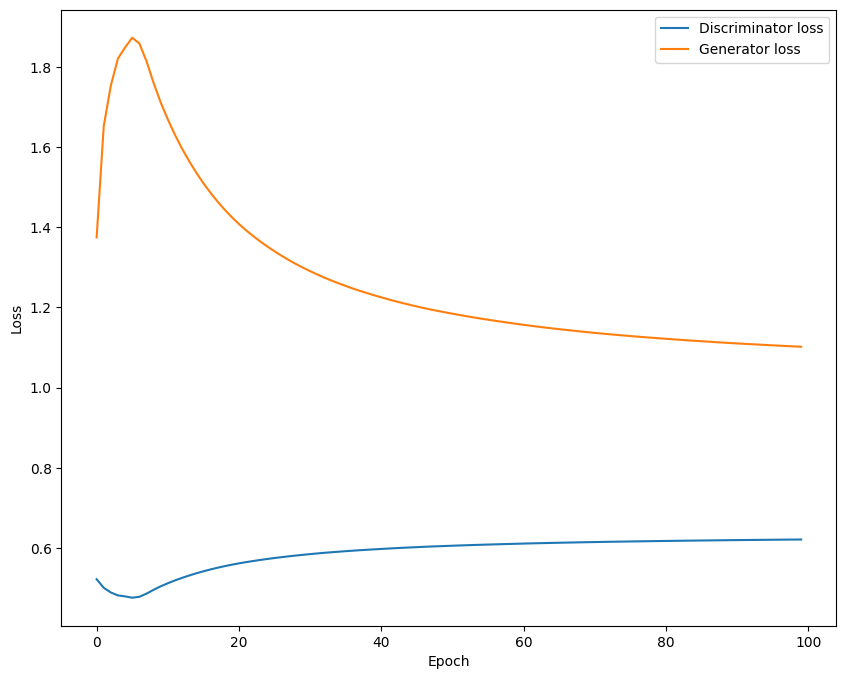

Generating final images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


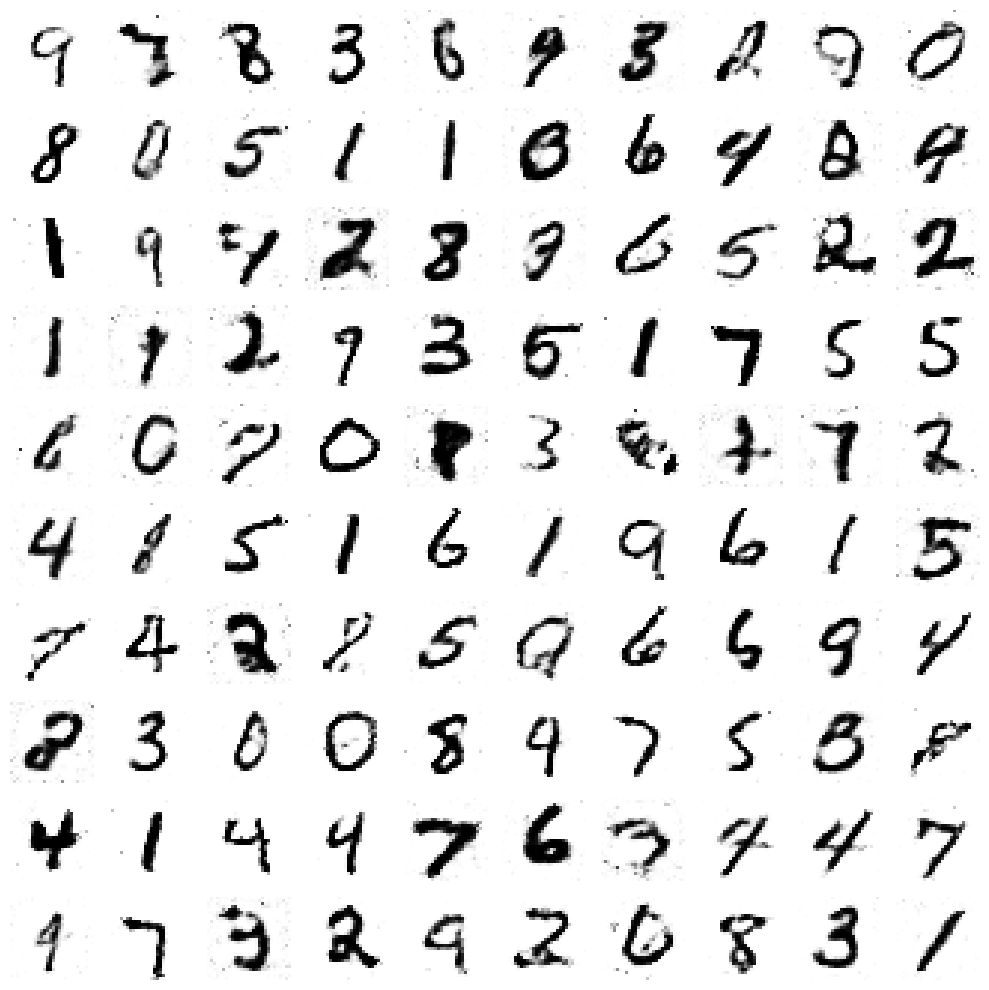

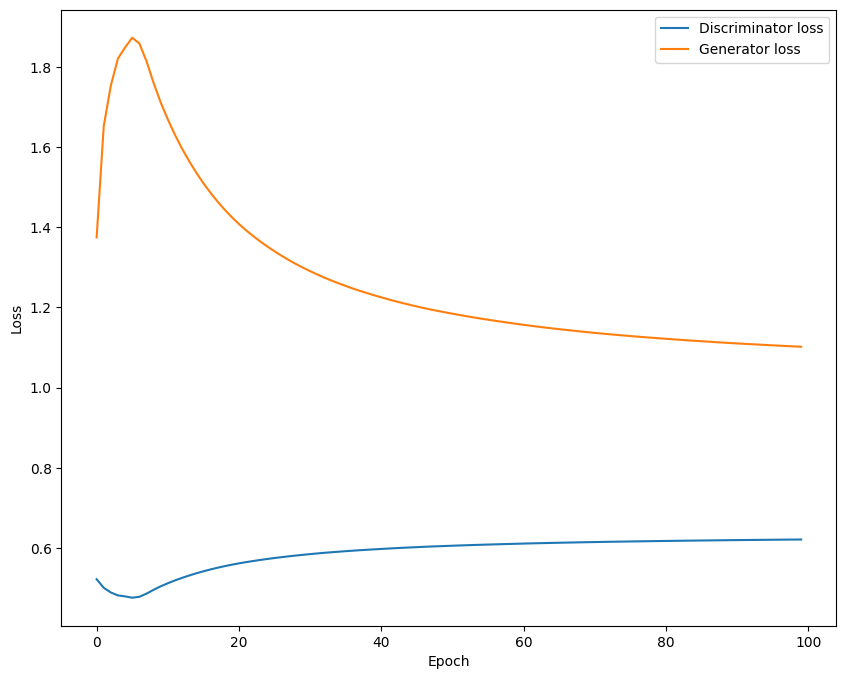

Training completed! Generated images saved in 'images' folder.
Expected results:
- Early epochs: Noisy, unrecognizable patterns
- Mid epochs (50-100): Digit-like shapes emerging
- Later epochs: Clear, recognizable handwritten digits
- Loss curves should show generator and discriminator in competition


In [ ]:
#Quick test before training
print("\nTesting model structure...")

#Generate a single random noise vector (1 sample, 100-dim)
test_noise = np.random.normal(0, 1, size=[1, randomDim])

#Pass noise through generator to create one fake image
test_generated = generator.predict(test_noise)

#Pass the fake image through discriminator to get "real vs fake" probability
test_discrimination = discriminator.predict(test_generated)

#Print results: shape of generated image and discriminator output
print(f"Test successful! Generated image shape: {test_generated.shape}, "
      f"Discrimination output: {test_discrimination}")

#Begin training the GAN
print("\nStarting GAN training...")
#Train for 100 epochs with batch size of 128
#Each epoch consists of alternating updates of discriminator and generator
train(epochs=100, batchSize=128)



#Generate final outputs after training
print("Generating final images...")

#Save a grid of final generated digits
saveGeneratedImages('final')

#Plot the loss curves of generator vs discriminator
plotLoss('final')

#Training completed summary
print("Training completed! Generated images saved in 'images' folder.")
print("Expected results:")
print("- Early epochs: Noisy, unrecognizable patterns")
print("- Mid epochs (50-100): Digit-like shapes emerging")
print("- Later epochs: Clear, recognizable handwritten digits")
print("- Loss curves should show generator and discriminator in competition")
